# Introduction

This project aims to predict the fare amount for NYC Yellow Taxi rides using historical trip data. The goal is to build a  model that can accurately estimate taxi fares based on trip characteristics such as pickup/dropoff location, distance, time, passenger count, and surcharges.

We used a clean and feature-engineered dataset that includes:

* Trip distance and duration

* Pickup hour and day

* Borough-level pickup/dropoff zones

* Surcharges (e.g., tolls, airport fees, congestion fees)

* Categorical variables like vendor ID, rate code, and payment type

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import ipywidgets as widgets
from IPython.display import IFrame,display, clear_output
from pandasql import sqldf
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Metadata

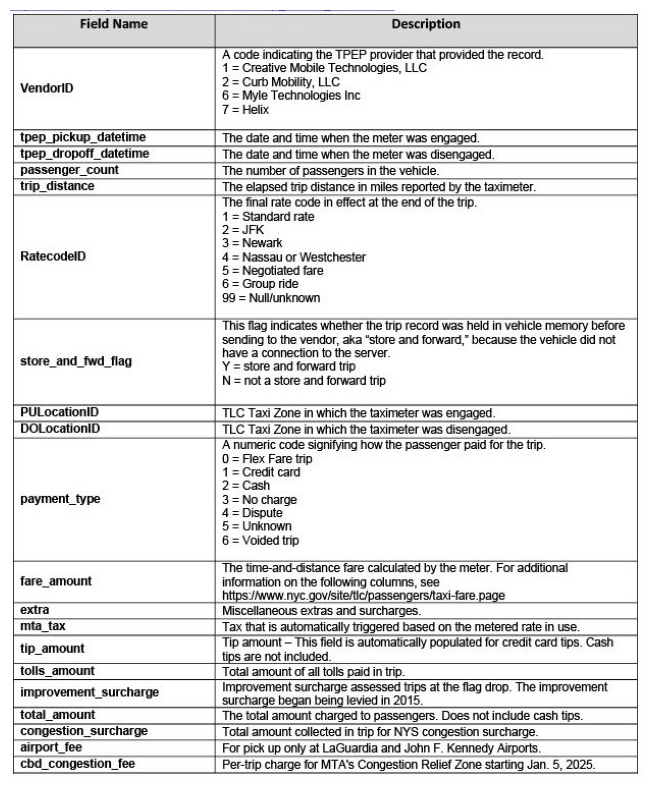

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('/kaggle/input/metadata/Metadata - Copy.jpg')
plt.figure(figsize=(16,10))
plt.imshow(img)
plt.axis('off')
plt.show()


# Loading Datasets

In [3]:
df_zone = pd.read_csv('/kaggle/input/taxi-zone-lookup/nyc_taxi_zone_lookup.csv')

In [4]:
df=pd.read_parquet('/kaggle/input/yellow-taxi-trip-data/yellow_tripdata_2025-01.parquet')
pd.set_option('display.max_columns',None)

# Data Cleaning and Feature Engineering

In [5]:
def wrangle(file):
    df = file.copy()
    # Creating new features
    df['trip_duration'] = (df['tpep_dropoff_datetime']- df['tpep_pickup_datetime']).dt.total_seconds()/60
    df['date'] = df['tpep_pickup_datetime'].dt.day
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    df['day'] = df['tpep_pickup_datetime'].dt.day_name()
    
    # subset mask
    # Choosing trips with passengers
    mask_passenger = df['passenger_count']>0
    
    # Excluding negative total amount
    mask_amount = df['total_amount'] >0
    
    # Excluding negative fare amount
    mask_fare = df['fare_amount']>0
    
    # Excluding negative, less than 1 minute and more than 3 hour trip duration
    mask_duration = (df['trip_duration']>1) & (df['trip_duration']<=180)
    
    # Excluding same pickup and dropoff locations
    mask_location= df['PULocationID']!=df['DOLocationID']
    
    # Excluding null or zero trip distance because it may be glitch or cancelled rides
    mask_distance = df['trip_distance'] > 0
    
    # Excluding payment type like disputed, voided, not charged and unknown
    mask_payment = df['payment_type'].isin([1,2])
    
    df= df[mask_passenger & mask_amount & mask_fare &\
           mask_duration & mask_location & mask_distance & mask_payment]
    
    # Excluding top 0.01% fare amount for abnormal amount 
    mask_quant = df['fare_amount'].quantile(0.9999)
    
    # Excluding top 0.01% trip distance for unusual distance with unusual amount 
    mask_quant1 = df['trip_distance'].quantile(0.9999)
    
    df = df[(df['fare_amount'] <= mask_quant) & (df['trip_distance'] <= mask_quant1)]
    
    # Joining pickup and drop location to get average duration and distance
    df['location'] = df['PULocationID'].astype(str)+" "+ df['DOLocationID'].astype(str)
    df['mean_duration'] = df.groupby('location')['trip_duration'].transform('mean')
    df['mean_distance'] = df.groupby('location')['trip_distance'].transform('mean')
    
    # Mapping pickup and drop location ID to its borough
    location_to_borough = df_zone.drop_duplicates('LocationID').set_index('LocationID')['borough']
    df['PUborough'] = df['PULocationID'].map(location_to_borough)
    df['DOborough'] = df['DOLocationID'].map(location_to_borough)

    return df

df = wrangle(df)

In [6]:
df.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,trip_duration,date,hour,day,location,mean_duration,mean_distance,PUborough,DOborough
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.6,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0,0.0,8.35,1,0,Wednesday,229 237,8.709295,1.003104,Manhattan,Manhattan
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.5,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0,0.0,2.55,1,0,Wednesday,236 237,7.712756,1.024842,Manhattan,Manhattan


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2639756 entries, 0 to 2935076
Data columns (total 29 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            floa

In [8]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,trip_duration,date,hour,mean_duration,mean_distance
count,2.639756e+06,2639756,2639756,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06,2.639756e+06
mean,1.776122e+00,2025-01-17 02:47:56.084442,2025-01-17 03:02:57.024378,1.306005e+00,3.274773e+00,2.474199e+00,1.664739e+02,1.655167e+02,1.128429e+00,1.825711e+01,1.609847e+00,4.963446e-01,3.627772e+00,5.443159e-01,9.866264e-01,2.786299e+01,2.333817e+00,1.345587e-01,4.966036e-01,1.501567e+01,1.649597e+01,1.439952e+01,1.501567e+01,3.274773e+00
min,1.000000e+00,2024-12-31 20:47:55,2024-12-31 20:54:00,1.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.010000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.016667e+00,1.000000e+00,0.000000e+00,1.116667e+00,2.000000e-02
25%,2.000000e+00,2025-01-09 16:44:17.750000,2025-01-09 17:01:19,1.000000e+00,1.050000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,1.600000e+00,0.000000e+00,1.000000e+00,1.638000e+01,2.500000e+00,0.000000e+00,0.000000e+00,7.500000e+00,9.000000e+00,1.100000e+01,8.307274e+00,1.057244e+00
50%,2.000000e+00,2025-01-16 21:17:46,2025-01-16 21:31:04.500000,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,3.000000e+00,0.000000e+00,1.000000e+00,2.085000e+01,2.500000e+00,0.000000e+00,7.500000e-01,1.175000e+01,1.600000e+01,1.500000e+01,1.183408e+01,1.690140e+00
75%,2.000000e+00,2025-01-24 17:42:26,2025-01-24 17:57:53,1.000000e+00,3.100000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.980000e+01,2.500000e+00,5.000000e-01,4.390000e+00,0.000000e+00,1.000000e+00,2.898000e+01,2.500000e+00,0.000000e+00,7.500000e-01,1.853333e+01,2.400000e+01,1.900000e+01,1.775714e+01,3.052232e+00
max,2.000000e+00,2025-02-01 00:00:44,2025-02-01 01:10:26,9.000000e+00,5.331000e+01,9.900000e+01,2.650000e+02,2.650000e+02,2.000000e+00,2.802000e+02,1.500000e+01,6.500000e+00,4.000000e+02,1.269400e+02,1.000000e+00,4.731500e+02,2.500000e+00,1.750000e+00,7.500000e-01,1.799667e+02,3.100000e+01,2.300000e+01,1.790500e+02,5.080000e+01
std,4.168415e-01,NaN,NaN,7.411312e-01,4.294653e+00,1.168357e+01,6.268889e+01,6.882023e+01,3.345673e-01,1.648678e+01,1.908897e+00,4.303526e-02,3.823155e+00,2.113119e+00,1.148683e-01,2.106124e+01,6.227687e-01,4.662313e-01,3.547360e-01,1.170025e+01,8.824265e+00,5.534417e+00,1.024858e+01,4.171322e+00


# Data Visualizations

##  Fare Distribution

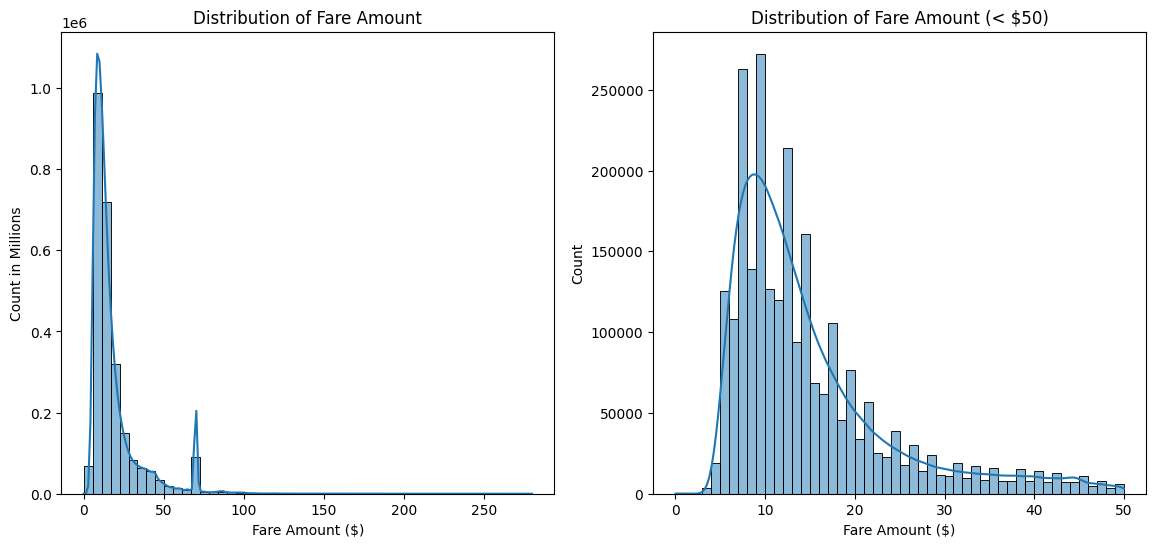

In [9]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Count in Millions')

plt.subplot(1, 2, 2)
sns.histplot(df[df['fare_amount'] < 50]['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount (< $50)')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Count')
plt.show()

## Distribution by Metrics

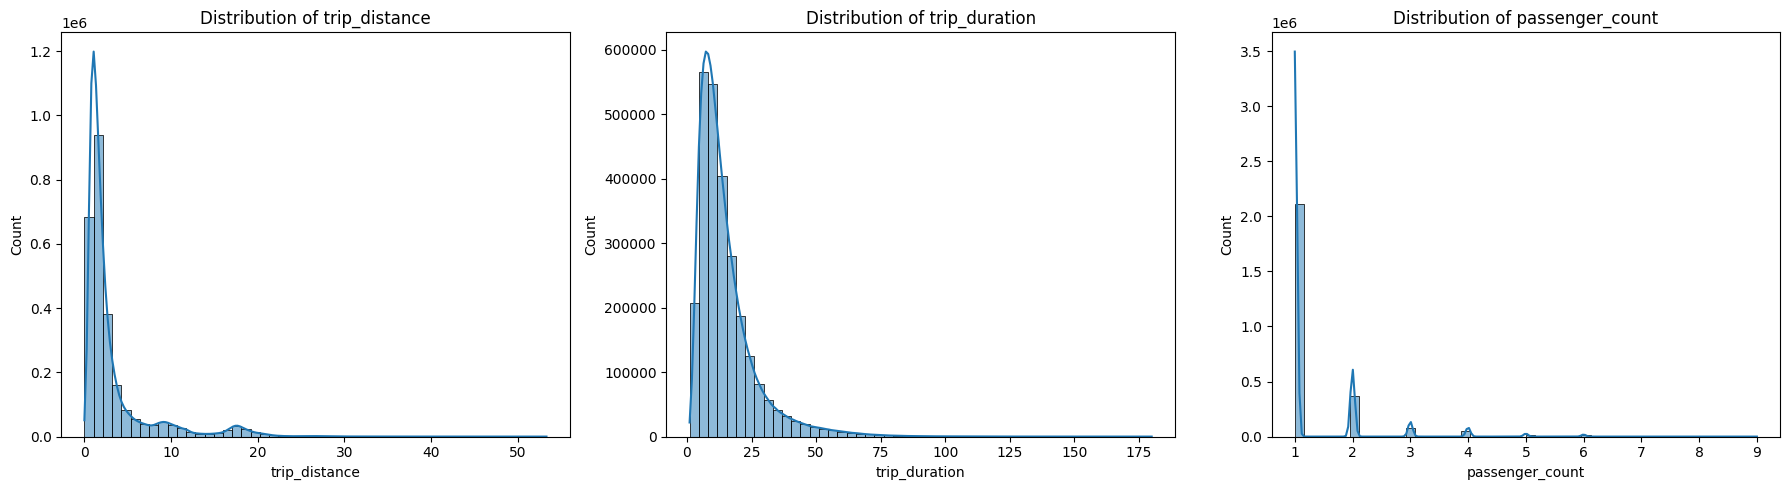

In [10]:
numerical_features = ['trip_distance', 'trip_duration', 'passenger_count']
plt.figure(figsize=(18, 5))
for i, col in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Count by Category

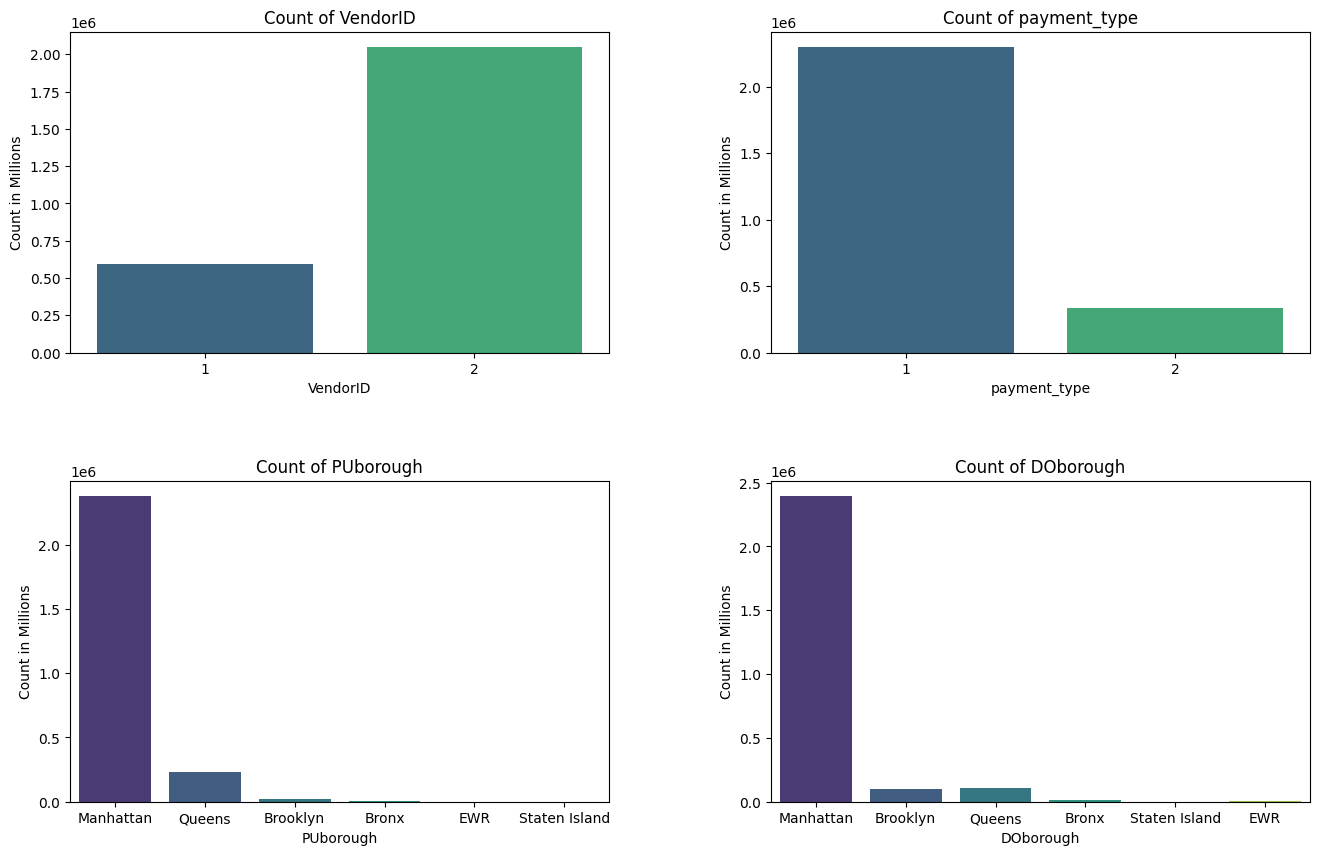

In [11]:
categorical_features= ['VendorID', 'payment_type','PUborough','DOborough']

plt.figure(figsize=(16, 10))
for i, col in enumerate(categorical_features):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=df, x=col, palette='viridis');
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count in Millions');
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show();


## Count By Metrics

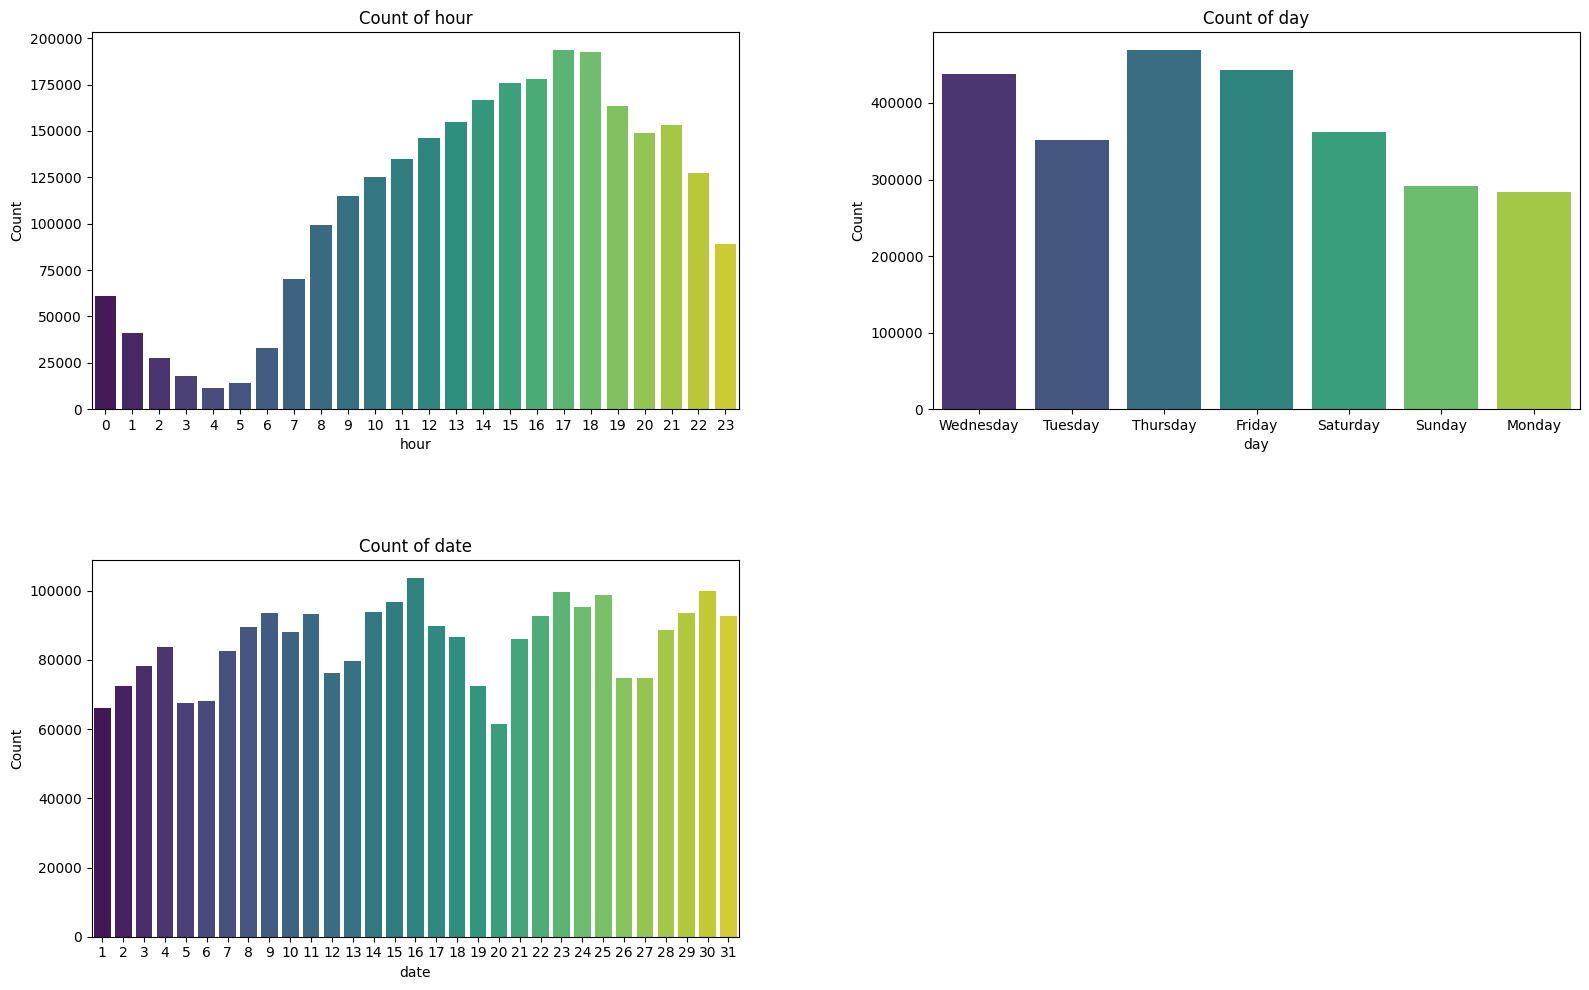

In [12]:
feature= ['hour','day','date']

plt.figure(figsize=(16, 10))
for i, col in enumerate(feature):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=df, x=col, palette='viridis');
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count');
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show();


## Distance & Duration 

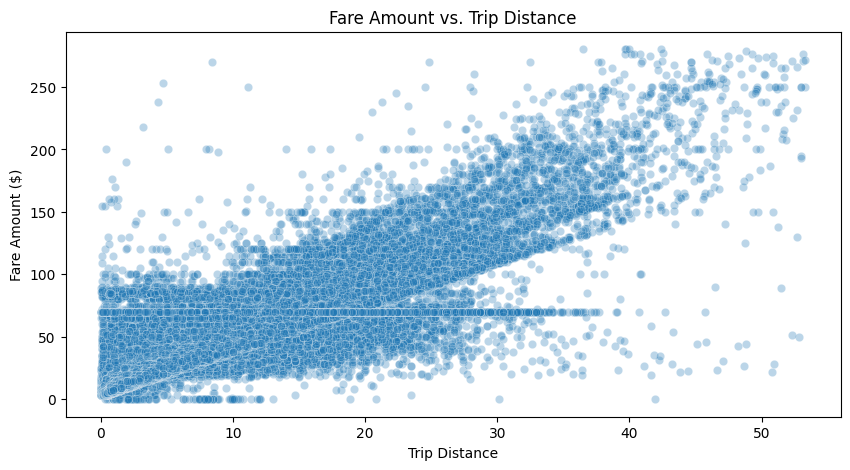

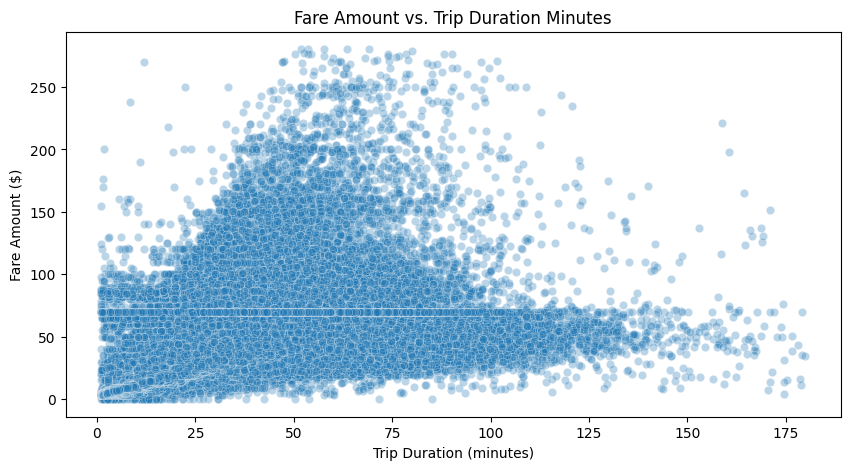

In [13]:
# Fare amount vs. Trip Distance
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='trip_distance', y='fare_amount', alpha=0.3)
plt.title('Fare Amount vs. Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount ($)')
plt.show()

# Fare amount vs. Trip Duration Minutes
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='trip_duration', y='fare_amount', alpha=0.3)
plt.title('Fare Amount vs. Trip Duration Minutes')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Fare Amount ($)')
plt.show()

## Correlation Matrix

* Removed columns with higher correlation

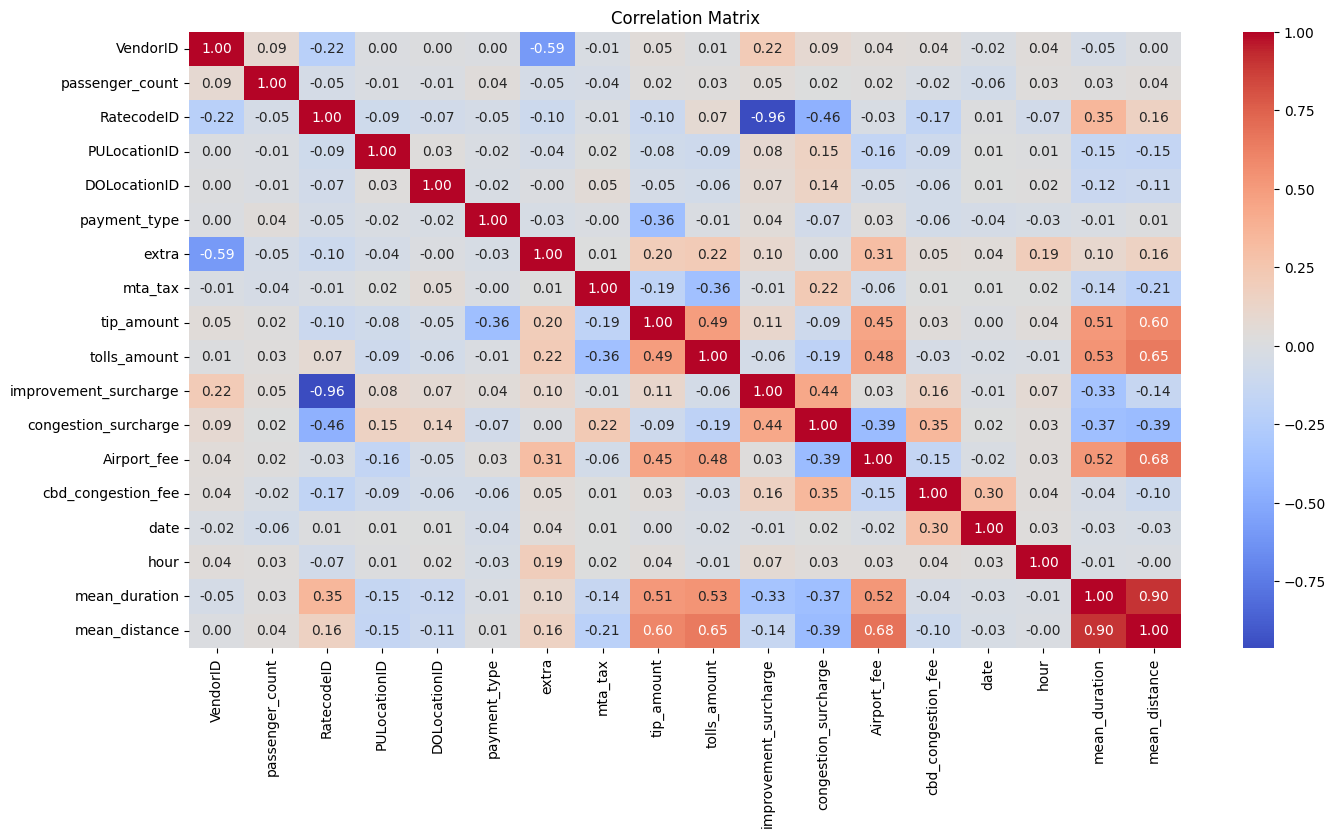

In [15]:
corr = df.drop(columns = df.select_dtypes('object')
               .columns.to_list()
               +['total_amount','fare_amount','trip_duration',\
                 'tpep_pickup_datetime','tpep_dropoff_datetime','trip_distance']
              ).corr()

plt.figure(figsize=(16,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix');

# Training Model

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['passenger_count', 'mean_distance', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'congestion_surcharge','Airport_fee','cbd_congestion_fee','date','hour','mean_duration']]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = zip(X, vif)
list(vif)

[('passenger_count', 4.145213605161156),
 ('mean_distance', 24.2674445388563),
 ('fare_amount', 20.91859039740171),
 ('extra', 2.0759695177916595),
 ('mta_tax', 82.94962580472621),
 ('tip_amount', 3.4549585503513764),
 ('tolls_amount', 2.122749542572255),
 ('improvement_surcharge', 86.01600372632662),
 ('congestion_surcharge', 27.827170139403783),
 ('Airport_fee', 2.6696030544475344),
 ('cbd_congestion_fee', 3.8946989292736784),
 ('date', 4.953927237914934),
 ('hour', 8.024588108304526),
 ('mean_duration', 24.76449031774304)]

In [17]:
def drop(file):
    df = file.copy()
    # Drop extra columns
    col = ['PULocationID','DOLocationID','trip_duration',\
           'trip_distance','tpep_pickup_datetime',\
           'tpep_dropoff_datetime','store_and_fwd_flag',\
           'location','mean_duration','mta_tax','improvement_surcharge',\
          'congestion_surcharge','fare_amount']

    df = df.drop(columns = col)
    
    # Change categorical columns into object
    col = ['VendorID','RatecodeID','payment_type',\
           'cbd_congestion_fee','Airport_fee']
    df[col] = df[col].astype('object')

    return df

In [18]:
df = drop(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2639756 entries, 0 to 2935076
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   VendorID            object 
 1   passenger_count     float64
 2   RatecodeID          object 
 3   payment_type        object 
 4   extra               float64
 5   tip_amount          float64
 6   tolls_amount        float64
 7   total_amount        float64
 8   Airport_fee         object 
 9   cbd_congestion_fee  object 
 10  date                int32  
 11  hour                int32  
 12  day                 object 
 13  mean_distance       float64
 14  PUborough           object 
 15  DOborough           object 
dtypes: float64(6), int32(2), object(8)
memory usage: 322.2+ MB


In [19]:

# Define target and features
X = df.drop(columns=['total_amount'])  
y = df['total_amount']                 

# Identify column types
categorical_cols = ['VendorID', 'RatecodeID', 'payment_type',\
                    'Airport_fee','cbd_congestion_fee', 'day', 'PUborough', 'DOborough']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Full pipeline
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model.fit(X_train, y_train)

print('Model Trained Succesfully')


Model Trained Succesfully


# Testing

* For testing we will use unseen data from **February 2025**
* As we can see model performed well:
  - **RMSE = 4.91** i.e. Average prediction error is ~$4.91
 
  - **MAE = 2.91** i.e Median like error is ~$2.91 

  - **R² = 0.9425** i.e. Model explains ~94.25% of fare variance

 

In [20]:
df_feb = pd.read_parquet('/kaggle/input/yellow-taxi-trip-data/yellow_tripdata_2025-02.parquet')
df_feb = wrangle(df_feb)
df_feb = drop(df_feb)
X_test = df_feb.drop(columns='total_amount')
y_test = df_feb['total_amount']

In [21]:

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")


RMSE: 4.91
MAE: 2.91
R² Score: 0.9425


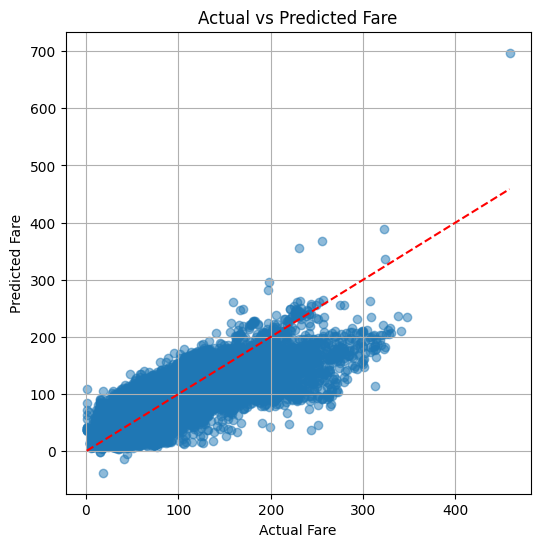

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Fare")
plt.grid(True)
plt.show()


# Conclusion

* Model generalizes well to unseen data, showing no signs of overfitting.

* Feature engineering (mean distance, pickup/drop boroughs, hour, etc.) played a key role in performance.

* A Linear Regression model with simple preprocessing achieved strong results, suggesting the fare distribution follows a mostly linear trend with respect to distance and time.

* This model could serve as a solid foundation for:

  - Fare estimator tools

  - Fare validation systems

  - Real-time apps (if enhanced with live GPS/traffic data)

# Widget

In [27]:
model = joblib.load("/kaggle/working/fare_predictor.pkl")

# Define widgets
distance = widgets.FloatSlider(min=0, max=20, step=0.1, value=2.5, description='Distance:')
hour = widgets.IntSlider(min=0, max=23, value=14, description='Hour:')
passenger_count = widgets.IntSlider(min=1, max=6, value=1, description='Passengers:')
borough = widgets.Dropdown(options=['Manhattan', 'Brooklyn', 'Queens'], description='PU Borough:')
vendor = widgets.Dropdown(options=['1', '2'], description='VendorID:')
ratecode = widgets.Dropdown(options=['1', '2', '3', '4', '5', '6'], description='RateCode:')
payment_type = widgets.Dropdown(options=['1', '2'], description='Payment:')
airport_fee = widgets.Dropdown(options=['No', 'Yes'], description='Airport Fee:')
cbd_fee = widgets.Dropdown(options=['No', 'Yes'], description='CBD Fee:')
day_of_week = widgets.Dropdown(options=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
], description='Day:')
predict_button = widgets.Button(description="Predict Fare")

# Prediction callback
def on_click(b):
    clear_output(wait=True)  # Clear previous outputs
    display_all()  # Re-show widgets
    try:
        input_df = pd.DataFrame([{
            'trip_distance': distance.value,
            'hour': hour.value,
            'passenger_count': float(passenger_count.value),
            'PUborough': borough.value,
            'DOborough': borough.value,
            'tip_amount': 0.0,
            'date': 15,
            'mean_distance': distance.value,
            'extra': 0.0,
            'tolls_amount': 0.0,
            'Airport_fee': airport_fee.value,
            'cbd_congestion_fee': cbd_fee.value,
            'VendorID': vendor.value,
            'RatecodeID': ratecode.value,
            'payment_type': payment_type.value,
            'day': day_of_week.value
        }])
        
        pred = model.predict(input_df)
        print(f"💰 Predicted Fare: ${pred[0]:.2f}")
    except Exception as e:
        print("⚠️ Error:", e)

# Display function
def display_all():
    display(
        distance, hour, passenger_count, borough,
        vendor, ratecode, payment_type,
        airport_fee, cbd_fee, day_of_week,
        predict_button
    )

predict_button.on_click(on_click)
display_all()


FloatSlider(value=2.5, description='Distance:', max=20.0)

IntSlider(value=14, description='Hour:', max=23)

IntSlider(value=1, description='Passengers:', max=6, min=1)

Dropdown(description='PU Borough:', options=('Manhattan', 'Brooklyn', 'Queens'), value='Manhattan')

Dropdown(description='VendorID:', options=('1', '2'), value='1')

Dropdown(description='RateCode:', options=('1', '2', '3', '4', '5', '6'), value='1')

Dropdown(description='Payment:', options=('1', '2'), value='1')

Dropdown(description='Airport Fee:', options=('No', 'Yes'), value='No')

Dropdown(description='CBD Fee:', options=('No', 'Yes'), value='No')

Dropdown(description='Day:', options=('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sun…

Button(description='Predict Fare', style=ButtonStyle())

# Streamlit Code (app.py)


##### Below is the sample code to simulate deployments

In [25]:
import joblib

joblib.dump(model, 'fare_predictor.pkl')


['fare_predictor.pkl']

In [26]:
import streamlit as st
import pandas as pd
import joblib

# Load trained pipeline
model = joblib.load("fare_predictor.pkl")

st.title("🚖 NYC Taxi Fare Predictor")

# Input fields
passenger_count = st.slider("Passenger Count", 1, 6, 1)
hour = st.slider("Pickup Hour", 0, 23, 12)
trip_distance = st.number_input("Trip Distance (miles)", min_value=0.1, value=1.0)
extra = st.number_input("Extra Charges", value=0.0)
tolls_amount = st.number_input("Tolls Amount", value=0.0)
Airport_fee = st.number_input("Airport Fee", value=0.0)
cbd_congestion_fee = st.number_input("CBD Congestion Fee", value=0.0)
VendorID = st.selectbox("Vendor ID", [1, 2])
RatecodeID = st.selectbox("Rate Code ID", [1, 2, 3, 4, 5, 6])
payment_type = st.selectbox("Payment Type", [1, 2])  # 1 = Credit, 2 = Cash
PUborough = st.selectbox("Pickup Borough", ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])
DOborough = st.selectbox("Dropoff Borough", ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])
day = st.selectbox("Day of Week", ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
date = st.slider("Day of Month", 1, 31, 15)
mean_distance = st.number_input("Mean Distance", value=1.5)
tip_amount = st.number_input("Tip Amount", value=0.0)


# Create input DataFrame
input_df = pd.DataFrame([{
    'passenger_count': passenger_count,
    'hour': hour,
    'trip_distance': trip_distance,
    'extra': extra,
    'tolls_amount': tolls_amount,
    'Airport_fee': Airport_fee,
    'cbd_congestion_fee': cbd_congestion_fee,
    'VendorID': VendorID,
    'RatecodeID': RatecodeID,
    'payment_type': payment_type,
    'PUborough': PUborough,
    'DOborough': DOborough,
    'day': day,
    'tip_amount': tip_amount,
    'mean_distance': mean_distance,
    'date': date

}])

# Predict and display
if st.button("Predict Fare"):
    predicted_fare = model.predict(input_df)
    st.success(f"💰 Predicted Fare: ${predicted_fare[0]:.2f}")


ModuleNotFoundError: No module named 'streamlit'